In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import NadamLocal
import matplotlib.pyplot as plt
import time
import numpy as np

%matplotlib inline

In [2]:
cuda = False
cuda = cuda and torch.cuda.is_available()

torch.manual_seed(1)
if cuda:
    torch.cuda.manual_seed(1)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True, **kwargs)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model_sgd = Net()
model_adam = Net()
model_nadam = Net()

if cuda:
    model_sgd.cuda()
    model_adam.cuda()
    model_nadam.cuda()

optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=.01, momentum=.5)
optimizer_adam = optim.Adam(model_adam.parameters())
optimizer_nadam = NadamLocal.Nadam(model_nadam.parameters())

In [5]:
def train(epoch):
    model_sgd.train()
    model_adam.train()
    model_nadam.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer_sgd.zero_grad()
        optimizer_adam.zero_grad()
        optimizer_nadam.zero_grad()

        output_sgd = model_sgd(data)
        output_adam = model_adam(data)
        output_nadam = model_nadam(data)

        loss_sgd = F.nll_loss(output_sgd, target)
        loss_adam = F.nll_loss(output_adam, target)
        loss_nadam = F.nll_loss(output_nadam, target)

        loss_sgd.backward()
        loss_adam.backward()
        loss_nadam.backward()

        optimizer_sgd.step()
        optimizer_adam.step()
        optimizer_nadam.step()

In [6]:
def test():
    model_sgd.eval()
    model_adam.eval()
    model_nadam.eval()

    test_loss_sgd = 0
    test_loss_adam = 0
    test_loss_nadam = 0

    correct_sgd = 0
    correct_adam = 0
    correct_nadam = 0

    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)

        output_sgd  = model_sgd(data)
        output_adam = model_adam(data)
        output_nadam = model_nadam(data)

        test_loss_sgd += F.nll_loss(output_sgd, target, size_average=False).data[0] # sum up batch loss
        test_loss_adam += F.nll_loss(output_adam, target, size_average=False).data[0] # sum up batch loss
        test_loss_nadam += F.nll_loss(output_nadam, target, size_average=False).data[0] # sum up batch loss

        pred_sgd = output_sgd.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred_adam = output_adam.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred_nadam = output_nadam.data.max(1, keepdim=True)[1] # get the index of the max log-probability

        correct_sgd += pred_sgd.eq(target.data.view_as(pred_sgd)).cpu().sum()
        correct_adam += pred_adam.eq(target.data.view_as(pred_adam)).cpu().sum()
        correct_nadam += pred_nadam.eq(target.data.view_as(pred_nadam)).cpu().sum()

    test_loss_sgd /= len(test_loader.dataset)
    test_loss_adam /= len(test_loader.dataset)
    test_loss_nadam /= len(test_loader.dataset)

    return (test_loss_sgd, test_loss_adam, test_loss_nadam)

In [7]:
def training_cost():
    model_sgd.eval()
    model_adam.eval()
    model_nadam.eval()

    train_loss_sgd = 0
    train_loss_adam = 0
    train_loss_nadam = 0

    correct_sgd = 0
    correct_adam = 0
    correct_nadam = 0

    for data, target in train_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)

        output_sgd  = model_sgd(data)
        output_adam = model_adam(data)
        output_nadam = model_nadam(data)

        train_loss_sgd += F.nll_loss(output_sgd, target, size_average=False).data[0] # sum up batch loss
        train_loss_adam += F.nll_loss(output_adam, target, size_average=False).data[0] # sum up batch loss
        train_loss_nadam += F.nll_loss(output_nadam, target, size_average=False).data[0] # sum up batch loss

        pred_sgd = output_sgd.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred_adam = output_adam.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred_nadam = output_nadam.data.max(1, keepdim=True)[1] # get the index of the max log-probability

        correct_sgd += pred_sgd.eq(target.data.view_as(pred_sgd)).cpu().sum()
        correct_adam += pred_adam.eq(target.data.view_as(pred_adam)).cpu().sum()
        correct_nadam += pred_nadam.eq(target.data.view_as(pred_nadam)).cpu().sum()

    train_loss_sgd /= len(train_loader.dataset)
    train_loss_adam /= len(train_loader.dataset)
    train_loss_nadam /= len(train_loader.dataset)

    return (train_loss_sgd, train_loss_adam, train_loss_nadam)

In [8]:
training_cost_v = []
test_cost_v = []
epochs = 10

for epoch in range(1, epochs + 1):
    train(epoch)
    test_cost_v.append(test())
    training_cost_v.append(training_cost())

/Users/yannigeorghiades/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


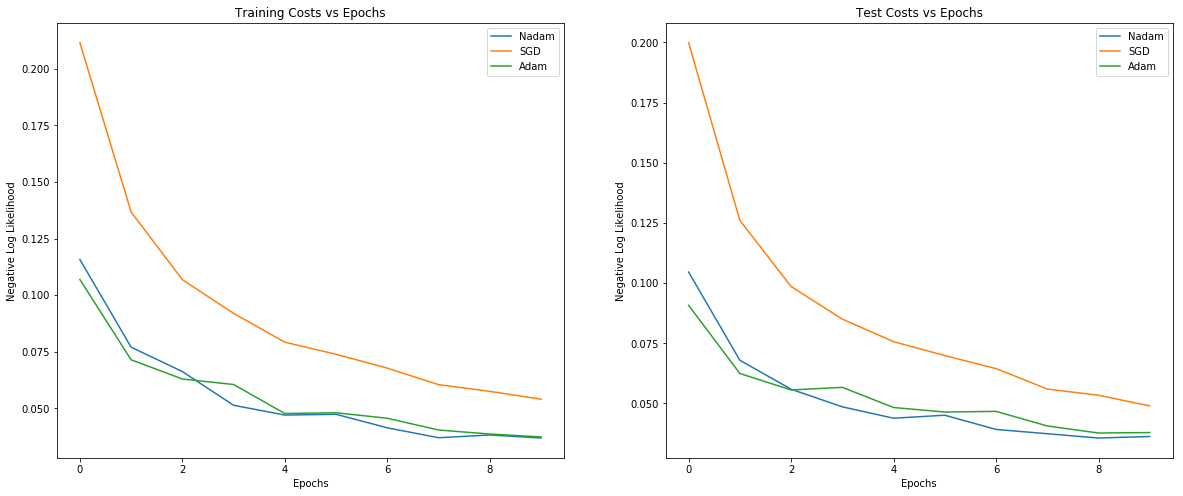

In [9]:
training_cost_v = np.asarray(training_cost_v)
test_cost_v = np.asarray(test_cost_v)

plt.clf()
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(training_cost_v.T[2], label='Nadam')
plt.plot(training_cost_v.T[0], label='SGD')
plt.plot(training_cost_v.T[1], label='Adam')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.title('Training Loss vs Epoch')

plt.subplot(1, 2, 2)
plt.plot(test_cost_v.T[2], label='Nadam')
plt.plot(test_cost_v.T[0], label='SGD')
plt.plot(test_cost_v.T[1], label='Adam')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.title('Test Loss vs Epoch')

plt.show()